In [1]:
# use CMU Serif
import matplotlib as mpl
import matplotlib.font_manager as font_manager
mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['text.usetex'] = True

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.transforms import Bbox

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os
import itertools
from utils import *

import sys
sys.path.append('/Users/theoares/lqcd/utilities')
from fittools import *
from formattools import *
# style = styles['prd_twocol']
style = styles['notebook']

## Process data and show current fits

In [2]:
# Set the ensemble index.
ens_idx = 0
ensemble = ['24I/ml_0p01', '24I/ml_0p005', '32I/ml0p008', '32I/ml0p006', '32I/ml0p004'][ens_idx]
ens_path = ['24I/ml0p01', '24I/ml0p005', '32I/ml0p008', '32I/ml0p006', '32I/ml0p004'][ens_idx]
f_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/bare_matrix_elements/' + ensemble + '/fit_params.h5'
n_ops = 5

# read in input to plot
f = h5py.File(f_path, 'r')
data_slice = f['data_slice'][()]
c = f['c'][()]
sigmac = f['sigmac'][()]
plot_domain = f['plot_domain'][()]
f.close()

data_plot_mu = np.mean(data_slice, axis = 0)
data_plot_sigma = np.std(data_slice, axis = 0, ddof = 1)

In [3]:
# set specific ranges and labels
ytick_labels = [
    [['-5.8', '-5.4', '-5.0'], ['-1.0', '-0.9', '-0.8'], ['3.4', '3.6', '3.8'], ['-1.9', '-1.7', '-1.5'], ['2.1', '2.3', '2.5']],         # 24I/ml0p01
    [['-5.0', '-4.7', '-4.4'], ['-8.5', '-8.0', '-7.5'], ['1.70', '1.85', '2.00'], ['-1.55', '-1.45', '-1.35'], ['1.80', '1.95', '2.10']],      # 24I/ml0p005
    [['-1.90', '-1.75', '-1.60'], ['-2.9', '-2.7', '-2.5'], ['8.00', '8.75', '9.50'], ['-5.8', '-5.3', '-4.8'], ['6.2', '6.7', '7.2']],      # 32I/ml0p008
    [['-1.70', '-1.55', '-1.40'], ['-2.7', '-2.5', '-2.3'], ['5.7', '6.2', '6.7'], ['-5.5', '-5.0', '-4.5'], ['5.8', '6.2', '6.6']],      # 32I/ml0p006
    [['-1.55', '-1.45', '-1.35'], ['-2.40', '-2.25', '-2.10'], ['3.4', '3.8', '4.2'], ['-4.9', '-4.5', '-4.1'], ['5.2', '5.6', '6.0']],      # 32I/ml0p004
][ens_idx]
pwr = [
    [-3, -2, -4, -2, -3],
    [-3, -3, -4, -2, -3],
    [-3, -3, -5, -3, -4],
    [-3, -3, -5, -3, -4],
    [-3, -3, -5, -3, -4]
][ens_idx]              # think about doing using \\text{-}
yrangep = [
    [[-0.0060, -0.0048], [-0.0105, -0.0075], [0.00033, 0.00039], [-0.02, -0.014], [0.0020, 0.0026]],
    [[-0.0051, -0.0043], [-0.00875, -0.00725], [0.000165, 0.000205], [-0.016, -0.013], [0.00175, 0.00215]],
    [[-0.002, -0.0015], [-0.0030, -0.0024], [0.0000775, 0.0000975], [-0.0061, -0.0045], [0.00059, 0.00075]],
    [[-0.00175, -0.00135], [-0.0028, -0.0022], [0.000054, 0.00007], [-0.00575, -0.00425], [0.00056, 0.00068]],
    [[-0.0016, -0.0013], [-0.00245, -0.00205], [0.000032, 0.000044], [-0.005, -0.004], [0.0005, 0.00062]]
][ens_idx]
ytick_locs = [[round(float(ytick_labels[k][i]) * (10 ** pwr[k]), np.abs(pwr[k]) + 2) for i in range(len(ytick_labels[k]))] for k in range(n_ops)]
# yaxis_labels = ['$' + latex_labels[ii] + '^{\\mathrm{eff}} \\hspace\{-1.0mm\} \\times \\hspace{-0.5mm} 10^{' + str(pwr[ii]) + '}$' for ii in range(len(latex_labels))]

latex_labels = [r'O_1', r'O_2', r'O_3', r'O_{1^\prime}', r'O_{2^\prime}']
yaxis_labels = [r'$' + latex_labels[ii] + r'^{\mathrm{eff}} \hspace{-1.0mm} \times \hspace{-0.5mm} 10^{' + str(pwr[ii]) + r'}$' for ii in range(len(latex_labels))]

In [4]:
asp_ratio = 4/3
fig_size = (style['colwidth'], style['colwidth'] / asp_ratio)
def plot_data(cvs, stds, yaxis_label, ylims = None, yt_locs = None, yt_labels = None, mrk = '.', col = 'r'):
    dom = plot_domain[:len(cvs)]
    with sns.plotting_context('paper'):
        plt.figure(figsize = fig_size)
        _, caps, _ = plt.errorbar(dom, cvs, yerr = stds, fmt = mrk, c = col, \
                     capsize = style['endcaps'], markersize = style['markersize'], elinewidth = style['ebar_width'])
        for cap in caps:
            cap.set_markeredgewidth(style['ecap_width'])
        plt.xlabel('$t / a$', fontsize = style['fontsize'])
        plt.ylabel(yaxis_label, fontsize = style['fontsize'])
        ax = plt.gca()
        ax.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
        ax.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
        if yt_locs:
            ax.set_yticks(yt_locs)
            ax.set_yticklabels(yt_labels)
        for spine in spinedirs:
            ax.spines[spine].set_linewidth(style['axeswidth'])
        plt.xticks(fontsize = style['fontsize'])
        plt.yticks(fontsize = style['fontsize'])
        #plt.xlim(0, max(list(plot_domain)) // 2 + 1.5)
        if ylims:
            plt.ylim(ylims[0], ylims[1])
        plt.tight_layout()
        plt.show()
def plot_fit(cvs, stds, fit_cvs, fit_stds, yaxis_label, ylims = None, yt_locs = None, yt_labels = None, mrk = '.', \
             col = 'r', fit_dom = plot_domain):
    dom = plot_domain[:len(cvs)]    # in case plot_domain needs truncation
    with sns.plotting_context('paper'):
        plt.figure(figsize = fig_size)
        _, caps, _ = plt.errorbar(dom, cvs, yerr = stds, fmt = mrk, c = col, \
                     capsize = style['endcaps'], markersize = style['markersize'], elinewidth = style['ebar_width'])
        plt.fill_between(fit_dom, fit_cvs - fit_stds, fit_cvs + fit_stds, color = col, alpha = 0.3, linewidth = 0.0)
        for cap in caps:
            cap.set_markeredgewidth(style['ecap_width'])
        plt.xlabel('$t / a$', fontsize = style['fontsize'])
        plt.ylabel(yaxis_label, fontsize = style['fontsize'])
        ax = plt.gca()
        ax.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
        ax.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
        if yt_locs:
            ax.set_yticks(yt_locs)
            ax.set_yticklabels(yt_labels)
        for spine in spinedirs:
            ax.spines[spine].set_linewidth(style['axeswidth'])
        plt.xticks(fontsize = style['fontsize'])
        plt.yticks(fontsize = style['fontsize'])
        plt.xlim(0, max(list(plot_domain)) // 2 + 1.5)
        if ylims:
            plt.ylim(ylims[0], ylims[1])
        plt.tight_layout()
        plt.show()

In [5]:
# Use this code block if I make this notebook into production code
f3pt_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/analysis_output/' +ensemble+ '/SD_output.h5'

f = h5py.File(f3pt_path, 'r')
L, T = f['L'][()], f['T'][()]
C2pt_tavg = f['pion-00WW'][()]
C2_pion00WP = np.real(f['pion-00WP'][()])
C3pt_tavg = f['C3pt'][()]
Cnpt = f['Cnpt'][()]
R_boot = f['R'][()]
f.close()

# fold 2-point
C2_fold = np.real(fold(C2pt_tavg, T))
C2_mu = np.mean(C2_fold, axis = 0)
C2_sigma = np.std(C2_fold, axis = 0, ddof = 1)

# get WP pion mass
meff = get_cosh_effective_mass(C2_pion00WP)
C2_folded = np.real(fold(C2_pion00WP, T))
meff_folded = fold_meff(meff, T)
meff_mu = np.mean(meff_folded, axis = 0)
meff_sigma = np.std(meff_folded, axis = 0, ddof = 1)

# process data points and make ready to fit
R_mu = np.mean(R_boot, axis = 0)
R_sigma = np.std(R_boot, axis = 0, ddof = 1)
data_slice = np.zeros((n_boot, n_ops, T), dtype = np.float64)
plot_domain = range(T)
for i in range(n_ops):
    for sep in range(T):
        if sep % 2 == 0:
            data_slice[:, i, sep] = np.real(R_boot[:, i, sep // 2, sep])
        else:
            data_slice[:, i, sep] = np.real((R_boot[:, i, sep // 2, sep] + R_boot[:, i, sep // 2 + 1, sep]) / 2)
data_plot_mu = np.mean(data_slice, axis = 0)
data_plot_sigma = np.std(data_slice, axis = 0, ddof = 1)

/Users/theoares/lqcd/0nubb/python_scripts/utils.py:220: ComplexWarning: Casting complex values to real discards the imaginary part
  folded[:, 0] = C[:, 0]
/Users/theoares/lqcd/0nubb/python_scripts/utils.py:223: ComplexWarning: Casting complex values to real discards the imaginary part
  folded[:, t + 1] = (C[:, t + 1] + C[:, T - (t + 1)]) / 2


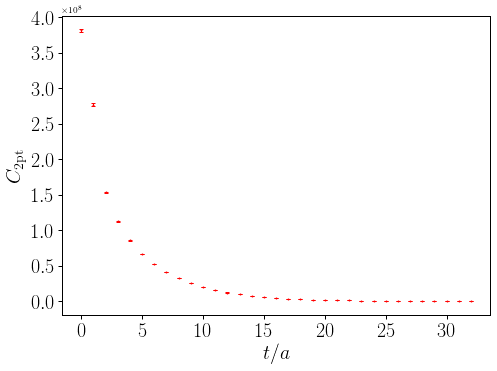

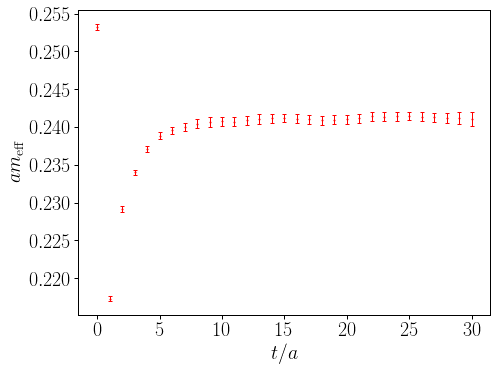

In [6]:
# plot 2-points
plot_data(C2_mu, C2_sigma, '$C_{2\mathrm{pt}}$')  # '$C_{2\mathrm{pt}}$'
plot_data(meff_mu, meff_sigma, '$am_{\mathrm{eff}}$')

Plotting operator O1


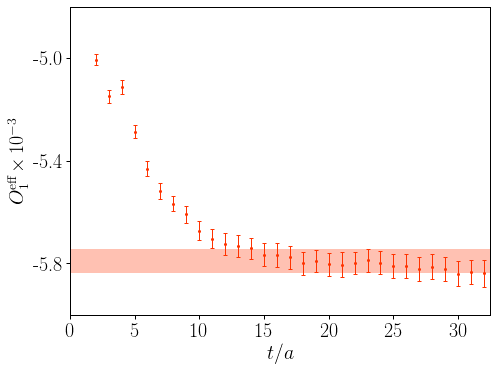

Plotting operator O2


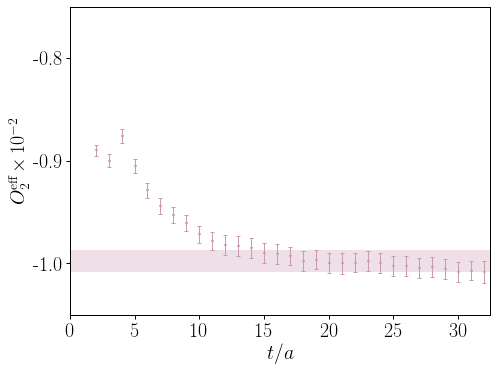

Plotting operator O3


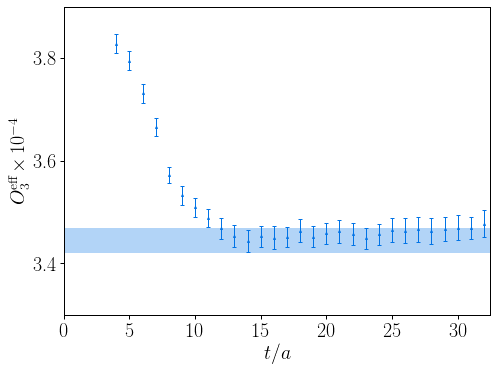

Plotting operator O1p


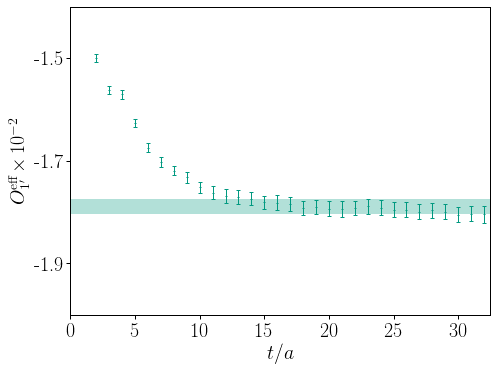

Plotting operator O2p


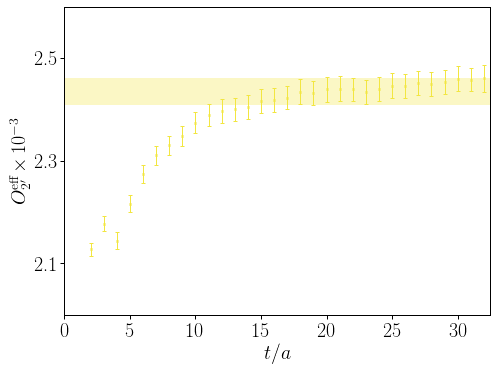

In [7]:
# plot 3-points
for i in range(n_ops):
    print('Plotting operator ' + str(op_labels[i]))
    plot_fit(data_plot_mu[i], data_plot_sigma[i], c[i], sigmac[i], yaxis_labels[i], yrangep[i], ytick_locs[i], \
            ytick_labels[i], markers[i], colors[i])

## Fit mpi

#### Constant fits to a given range

In [8]:
def const(params):
    def model(t):
        return params[0]
    return model
constant_model = Model(const, 1, [''], ['c0'])

In [9]:
mpi_domain = np.arange(12, 29)
fitter = BootstrapFitter(mpi_domain, meff_folded[:, mpi_domain], constant_model)
# fitter = UncorrFitter(mpi_domain, meff_mu[mpi_domain], meff_sigma[mpi_domain], constant_model)
mpi_params_c, chi2_c, ndof_c, mpi_covar_c = fitter.fit()
mpi_mu_c = mpi_params_c[0]
mpi_std_c = np.sqrt(mpi_covar_c[0, 0])
print('Mpi = ' + export_float_latex(mpi_mu_c, mpi_std_c) + ' with chi^2 / ndof = ' + str(chi2_c / ndof_c))

Fitting data: [0.24088537 0.24106982 0.24118419 0.24119754 0.24111457 0.24104779
 0.24091662 0.24098462 0.2410112  0.24117734 0.24141461 0.24138038
 0.24141176 0.24146834 0.24136726 0.24130491 0.24122685] at x positions: [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28]
Mpi = 0.24125(38) with chi^2 / ndof = 1.445793315314252


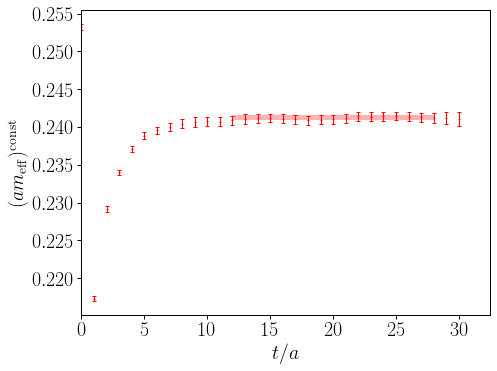

In [10]:
plot_fit(meff_mu, meff_sigma, mpi_mu_c, mpi_std_c, '$(am_{\mathrm{eff}})^{\mathrm{const}}$', fit_dom = mpi_domain)

#### Excited state fits

In [11]:
def single_exp(params):
    def model(t):
        return params[0] * np.exp(-params[1] * t)# + params[2] * np.exp(-(params[1] + params[3]) * t)
    return model
def multi_exp(params):
    def model(t):
        return params[0] * np.exp(-params[1] * t) + params[2] * np.exp(-(params[1] + params[3]) * t)
    return model
# TODO put prior on params[3] (which is Δ, the energy gap)
single_exp_model = Model(single_exp, 2, ['', 't'], ['Z0', 'm0'])
multi_exp_model = Model(single_exp, 4, ['', 't', '', 't'], ['Z0', 'm0', 'Z1', 'Δ'])

In [ ]:
# use gvar, lsqfit, and corr_fitter

In [ ]:
# mpi_domain_exc = np.arange(12, 29)
mpi_domain_exc = np.arange(12, 16)
fitter_e = BootstrapFitter(mpi_domain, meff_folded[:, mpi_domain], single_exp_model)
# fitter = UncorrFitter(mpi_domain, meff_mu[mpi_domain], meff_sigma[mpi_domain], constant_model)
mpi_params_e, chi2_e, ndof_e, mpi_covar_e = fitter_e.fit()
print(mpi_params_e)
mpi_mu_e = mpi_params_e[1]
mpi_std_e = np.sqrt(mpi_covar_e[1, 1])
print('Mpi = ' + export_float_latex(mpi_mu_c, mpi_std_c) + ' with chi^2 / ndof = ' + str(chi2_c / ndof_c))

## Fit 3-point functions

#### Constant fits to given range

In [ ]:
const_domain = [
    [np.arange(17, 29), np.arange(17, 29), np.arange(17, 29), np.arange(17, 29), np.arange(17, 29)], 
    [np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1)], 
    [np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1)], 
    [np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1)], 
    [np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1)]
][ens_idx]

#### Excited state fit

In [ ]:
exc_domain = [
    [np.arange(17, 29), np.arange(17, 29), np.arange(17, 29), np.arange(17, 29), np.arange(17, 29)], 
    [np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1)], 
    [np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1)], 
    [np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1)], 
    [np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1)]
][ens_idx]

### Write out results

In [ ]:
# out_file = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/bare_matrix_elements/' + ensemble + '/fit_params.h5'
# fout = h5py.File(out_file, 'w')
# fout['fits'] = fits
# fout['data_slice'] = data_slice
# fout['c'] = np.array(c)
# fout['sigmac'] = np.array(sigmac)
# fout['plot_domain'] = plot_domain
# fout.close()
# print('Results output to: ' + out_file)